# DORIS Range-Rate Observation Equation (Simplistic Approach)

We can formulate range-rate observation equations using the Doppler count data extracted from the DORIS RINEX files. A simplistic approach (disregarding all errors) would be to use the simple equation:

$$ \frac{\phi (t_2) - \phi (t_1)}{\Delta t} \cdot \frac{c}{f} = \frac{\rho (t_2) - \rho (t_1)}{\Delta t} $$ in [m/sec], where $\rho (t)$ is the beacon-to-satellite distance.

In [17]:
# import dsoclasses
import datetime
import attotime
import numpy as np
from dsoclasses.doris.algorithms import beacon_nominal_frequency
from dsoclasses.rinex.doris.rinex import DorisRinex
from dsoclasses.time.pyattotime import at2pt, fsec2asec
from dsoclasses.orbits import sp3c, interpolator
from dsoclasses.geodesy import transformations
from dsoclasses.gnss import systems as gs
from dsoclasses.gnss import algorithms as alg
from dsoclasses.troposphere import gmf, gpt3, tropo
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import math

We will need onr DORIS RINEX file and a corresponding sp3.

In [18]:
drinex = "/home/geosere/Desktop/data/s6arx24001.001"
dsp3 = "/home/geosere/Desktop/data/ssas6a20.b23357.e24001.DG_.sp3.001"

We will also need a meteorological data GPT3 file (Global Pressure Temperature File)

In [19]:
gpt3_file = "/home/geosere/Desktop/data/gpt3_5.grd"

We will also need an interpolator to compute satellite state at any observation epoch.

In [20]:
sp3 = sp3c.Sp3(dsp3)
satid = sp3.sat_ids[0]
sp3_data = sp3.get_satellite(satid, True)
intrp = interpolator.OrbitInterpolator(satid, sp3_data, 1800, 12, 'CubicSpline')

Intitialize the `DorisRinex` instance and select a beacon (Dionysos/DIOB).
The following block calculates the residuals accounting for: 
    1) Ionospheric correction (uses ionospheric corrected L3 band + phase).
    2) Uses a smoothed frequency offset data set to correct the frequency error.
    3) Accounts for the correction of abberation error.

In [21]:
rnx = DorisRinex(drinex)

# DIOB DORIS beacon
diob = 'D31'

# approx. DIOB coordinats, see https://ids-doris.org/network/sitelogs/station.html?code=DIONYSOS
diob_xyz=np.array([4595212.468, 2039473.691, 3912617.891])

In [22]:
lat, lon, hgt = transformations.car2ell(*diob_xyz)
Rt = transformations.geodetic2lvlh(lat, lon)
R = Rt.transpose()
print(f"[DEBUG] DIOB φ: {np.degrees(lat):.6f}°, λ: {np.degrees(lon):.6f}°, h: {hgt:.2f} m")

def azele(rsat, rsta):
    enu = R @ (rsat - rsta)
    r  = np.linalg.norm(enu)
    az = np.arctan2(enu[0], enu[1])
    el = np.arcsin(enu[2] / r)
    return r, az, el

#Get indices for every pass
def compute_pass_indices(times, threshold_sec=600):
    pass_indices = []
    current_pass = 0
    last_time = times[0]

    for t in times:
        delta_t = (t - last_time).total_seconds()
        if delta_t > threshold_sec:
            current_pass += 1  # Νέο pass αν το κενό είναι μεγάλο
        pass_indices.append(current_pass)
        last_time = t

    return pass_indices

[DEBUG] DIOB φ: 38.078445°, λ: 23.932882°, h: 512.79 m


In [23]:
#Προετοιμασία για τον υπολογισμο του f

t_all = []; F_all = [];

k_diob = 32    #shift factor for DIOB beacon
feN2, feN4 = beacon_nominal_frequency(k_diob)
print(f"feN2 (2 GHz channel) = {feN2:.9f} Hz")
print(f"feN4 (400 MHz channel) = {feN4:.9f} Hz")

frN = ((feN2**2 - feN4**2) / (feN2 - feN4))
sf = (feN2 / feN4)**2
feN_L3 = (sf * feN2 - math.sqrt(sf) * feN4) / (sf - 1)


# for every block in the RINEX file
for block in rnx:
    # for every beacon in the block
    for beacon, data in block:
            # use the block, RINEX provided clock correction to get to (approximate) TAI
            # date TAI = epoch + receiver clock offset
            t2 = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset()*1e9)
            t_all.append(at2pt(t2))
            #get frequency offset from block
            F = data['F']['value']
            F_all.append(F)

t0 = t_all[0]
t_seconds = [(ti - t0).total_seconds() for ti in t_all]

smoothing_coeffs = np.polyfit(t_seconds, F_all, 4)
F_smooth_fn = np.poly1d(smoothing_coeffs)

feN2 (2 GHz channel) = 2036272526.264190674 Hz
feN4 (400 MHz channel) = 401254438.877105713 Hz


In [24]:
# initially, no previous phase observation ...
t1=None
dT2 = None
satx_prev = None 
saty_prev = None 
satz_prev = None

# store results here 
t = []; res2=[]; raw_obs = []; el_valid = []; dT_list = [];

# for every block in the RINEX file
for block in rnx:
    # for every beacon in the block
    for beacon, data in block:
        # match DIOB
        if beacon == diob:
            # use the block, RINEX provided clock correction to get to (approximate) TAI
            # date TAI = epoch + receiver clock offset
            t2 = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset()*1e9)
            # satellite position at the current epoch (taking into account signal travel time)
            satx, saty, satz, _, _ = alg.sat_at_emission_time(diob_xyz, t2, intrp, None)
            rsat2 = np.array([satx, saty, satz])
            # tropospheric delay
            r2 = np.linalg.norm(np.array([satx, saty, satz])-np.array(diob_xyz))
            _, _, el = azele(np.array((satx, saty, satz)), np.array(diob_xyz))
            dT = tropo.tropo_delay(np.array(diob_xyz), t2, el, gpt3_file)

            #Filter for clearing outliers for the dT_diff
            dT_diff = dT - dT2 if dT2 is not None else 0.0
            
            # L1 and L2 measurements
            L2_1 = data['L1']['value']
            L2_2 = data['L2']['value']
            #L3 build
            L3 = (sf*L2_1 - math.sqrt(sf)*L2_2)/(sf-1)
            
            # --- Λειασμένη συχνότητα F
            t2_sec = (at2pt(t2) - t0).total_seconds()
            F_smoothed = F_smooth_fn(t2_sec)
            #print(f"{frT:.3f} {frN:.3f}")
            # --- frT με βάση την λειασμένη F
            frT = frN * (1 + F_smoothed * 1e-11)
            
            # beacon-to-satellite distance
            r2 = np.linalg.norm(np.array([satx, saty, satz])-np.array(diob_xyz))

            # if we have a previous measurement, within 10 sec ...
            if t1 is not None and (t2 - t1).total_seconds() <= 10.:
                # computed range-rate
                crr = (r2 - r1) / (float((t2-t1).total_nanoseconds()) * 1e-9)
                # observed range-rate
                orr = (((L3 - L1) / (float((t2-t1).total_nanoseconds()) * 1e-9)) + frT - frN) * (299792458.0 / feN_L3)
                # very loose outlier detection
                if abs(orr - crr) > 10.:
                    pass
                else:
                    t.append(at2pt(t2))
                    el_valid.append(np.degrees(el))
                    dT_list.append(dT)
                    res2.append(orr - crr)
                    raw_obs.append({
                        'rsat1': np.array([satx_prev, saty_prev, satz_prev]),
                        'rsat2': rsat2,
                        'dt': (float((t2-t1).total_nanoseconds()) * 1e-9),
                        'v_obs': orr,
                        'dT': (dT2 - dT) if dT2 is not None else 0.0,
                    })
                #print(f"Διάστημα t2 - t1 = {(t2 - t1).total_seconds():.6f} seconds")
            # prepare for next measurement
            dT2 = dT
            r1 = r2
            t1 = t2
            L1 = L3
            satx_prev, saty_prev, satz_prev = satx, saty, satz

print("Μήκος dT_list:", len(dT_list))
print("Μήκος el_list:", len(el_valid))
print("Μήκος t:", len(t))

Μήκος dT_list: 1109
Μήκος el_list: 1109
Μήκος t: 1109


In [ ]:
for ti, elev, dT in zip(t, el_valid, dT_list):
    print(f"t = {ti}, Elevation = {elev:.2f}°, dT = {dT:.4f} m")

with open("tropo_output.txt", "w") as f:
    f.write("Time,Elevation_deg,dT_m\n")
    for ti, elev, dT in zip(t, el_valid, dT_list):
        f.write(f"{ti},{elev:.2f},{dT:.4f}\n")

In [25]:
# Αρχική εκτίμηση beacon (π.χ. DIOB)
pass_indices = compute_pass_indices(t, threshold_sec=600)
Np = max(pass_indices) + 1   # Αριθμός passes
#print(f"Total passes: {Np}")

#Ορισμός λίστας x0
x0 = np.zeros(4 + Np)        # [x, y, z, Δf, ΔT_pass1, ΔT_pass2, ..., ΔT_passNp]
x0[0:3] = diob_xyz           # Αρχική θέση beacon

m = len(raw_obs)                      # αριθμός παρατηρήσεων
J = np.zeros((m, 4 + Np))             # Ιακωβιανός πίνακας
dl = np.zeros(m)                      # διάνυσμα residuals

LS_ITERATIONS = 3                     # επαναλήψεις Least Squares

for ls_iteration in range(LS_ITERATIONS):
    for i, obs in enumerate(raw_obs):
        rsat1 = obs['rsat1']
        rsat2 = obs['rsat2']
        dt = obs['dt']
        v_obs = obs['v_obs']
        dT = obs['dT']
        r_beacon = x0[0:3]
        delta_f = x0[3]
        pass_id = pass_indices[i]
        delta_T = x0[4 + pass_id]
        
        #print(f"obs {i}: dT = {dT:.3f} m")
        
        # υπολογισμός θεωρητικής ταχύτητας
        r1 = np.linalg.norm(rsat1 - r_beacon)
        r2 = np.linalg.norm(rsat2 - r_beacon)
        #v_theo = (r2 - r1 + dT) / dt
        v_theo = (r2 - r1) / dt
        
        # residual
        dl[i] = v_obs - delta_f - v_theo + obs['dT']/dt - delta_T/dt
        
        if abs(dl[i]) > 10.0:
            print(f"Skipping obs {i} due to large residual: {dl[i]:+.3f} m/s")
            dl[i] = 0.0
            J[i, :] = 0.0
            continue

        # παράγωγος του v_theo ως προς x, y, z beacon (γραμμή του Ιακωβιανού)
        J[i, 0:3] = (r_beacon - rsat2) / (r2 * dt) - (r_beacon - rsat1) / (r1 * dt)
        J[i, 3] = +1.0

        pass_id = pass_indices[i]
        J[i, 4 + pass_id] = 1.0 / dt

    # least squares επίλυση
    dx, *_ = np.linalg.lstsq(J, dl, rcond=None)
    x0 += dx

    # a-posteriori σφάλμα μονάδας βάρους
    sigma = np.sqrt(np.sum(dl**2) / (m - (4 + Np)))

    print(f"Iteration {ls_iteration+1}: Δx = ({dx[0]:+.3f}, {dx[1]:+.3f}, {dx[2]:+.3f}) | Δf = {dx[3]:+.6f} | σ = {sigma:.3f}")
    print(f"m = {m}, n = {J.shape[1]}")


Skipping obs 187 due to large residual: -29.540 m/s
Iteration 1: Δx = (-20.760, -16.082, -22.909) | Δf = +2.659772 | σ = 2.676
m = 1109, n = 12
Skipping obs 187 due to large residual: -32.162 m/s
Iteration 2: Δx = (-0.000, -0.000, -0.000) | Δf = -0.000000 | σ = 0.047
m = 1109, n = 12
Skipping obs 187 due to large residual: -32.162 m/s
Iteration 3: Δx = (-0.000, -0.000, -0.000) | Δf = -0.000000 | σ = 0.047
m = 1109, n = 12


In [19]:
dl_filtered = []
t_filtered = []

for i in range(len(dl)):
    if abs(dl[i]) <= 10.0:
        dl_filtered.append(dl[i])
        t_filtered.append(t[i])
    else:
        print(f"Rejected: dl = {dl[i]:+.3f} m/s at t = {t[i]}")

## 📡 Beacon Coordinates Correction

### Initial Coordinates
**X:** 4595212.468 **Y:** 2039473.691 **Z:** 3912617.891 *(m)*

---

### Corrected Without dT
**X:** 4595205.680 **Y:** 2039492.927 **Z:** 3912618.462 *(m)*  
**Δx:** –6.788 m  **Δy:** +19.236 m **Δz:** +0.571 m  
**‖Δr‖ = 20.406 m**

---

### Corrected With dT (only GPT3
**X:** 4595218.579 **Y:** 2039582.637 **Z:** 3912647.841 *(m)*  
**Δx:** +6.111 m  **Δy:** +108.946 m **Δz:** +29.950 m  
**‖Δr‖ = 113.153 m**

### Corrected With dT + estimation
**X:** 4595191.708 **Y:** 2039457.609 **Z:** 3912594.982 *(m)*  
**Δx:** -20.760 m  **Δy:** -16.082 m **Δz:** -22.909 m  
**‖Δr‖ = 34.849 m**


In [23]:
print("\nΤελικές εκτιμήσεις:")
print(f"Θέση beacon (x, y, z): ({x0[0]:.3f}, {x0[1]:.3f}, {x0[2]:.3f}) m")
print(f"Δf (frequency bias): {x0[3]:.6e} m")
for i in range(Np):
    print(f"ΔT_pass{i+1}: {x0[4 + i]:.6f} m")


Τελικές εκτιμήσεις:
Θέση beacon (x, y, z): (4595191.708, 2039457.609, 3912594.982) m
Δf (frequency bias): 2.659772e+00 m
ΔT_pass1: -0.101922 m
ΔT_pass2: -0.020350 m
ΔT_pass3: -0.013808 m
ΔT_pass4: -0.031359 m
ΔT_pass5: -0.069238 m
ΔT_pass6: -0.023576 m
ΔT_pass7: 0.022690 m
ΔT_pass8: 0.040831 m


In [13]:
# Αρχικές συντεταγμένες
x_init, y_init, z_init = diob_xyz

# Τελικές (διορθωμένες) συντεταγμένες
x_corr, y_corr, z_corr = x0[0:3]

# Διαφορά ανά άξονα
dx = x_corr - x_init
dy = y_corr - y_init
dz = z_corr - z_init

# Συνολική μετατόπιση
dr = np.linalg.norm([dx, dy, dz])

# Εκτύπωση
print("\n--- Beacon Coordinates Correction ---")
print(f"Initial  : X = {x_init:.3f}, Y = {y_init:.3f}, Z = {z_init:.3f} [m]")
print(f"Corrected: X = {x_corr:.3f}, Y = {y_corr:.3f}, Z = {z_corr:.3f} [m]")
print(f"Δx = {dx:.3f} m, Δy = {dy:.3f} m, Δz = {dz:.3f} m → |Δr| = {dr:.3f} m")


--- Beacon Coordinates Correction ---
Initial  : X = 4595212.468, Y = 2039473.691, Z = 3912617.891 [m]
Corrected: X = 4595191.708, Y = 2039457.609, Z = 3912594.982 [m]
Δx = -20.760 m, Δy = -16.082 m, Δz = -22.909 m → |Δr| = 34.849 m


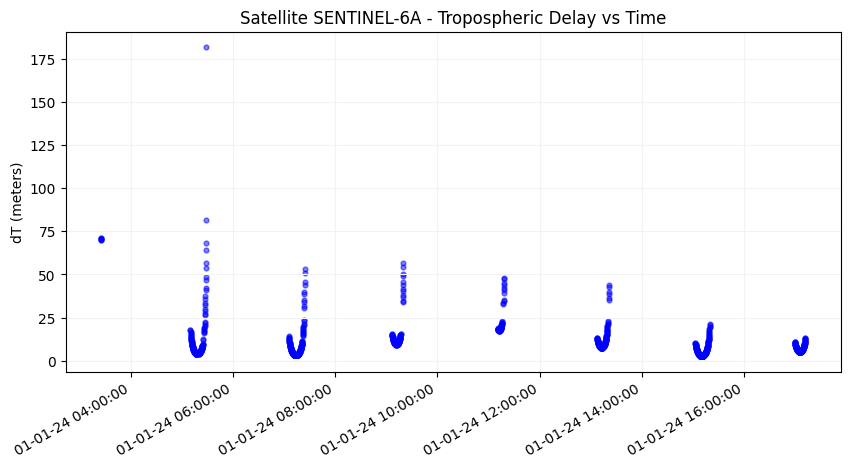

In [12]:
# ---- Scatter Plot Tropospheric Delay ----
plt.figure(figsize=(10, 5))

plt.scatter(t, dT_list, alpha=0.5, s=12, c='blue')

plt.grid(color='0.95')
plt.ylabel("dT (meters)")
plt.title(f"Satellite {rnx.sat_name} - Tropospheric Delay vs Time")

# Format the datetime x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y %H:%M:%S"))
plt.gcf().autofmt_xdate()

plt.show()

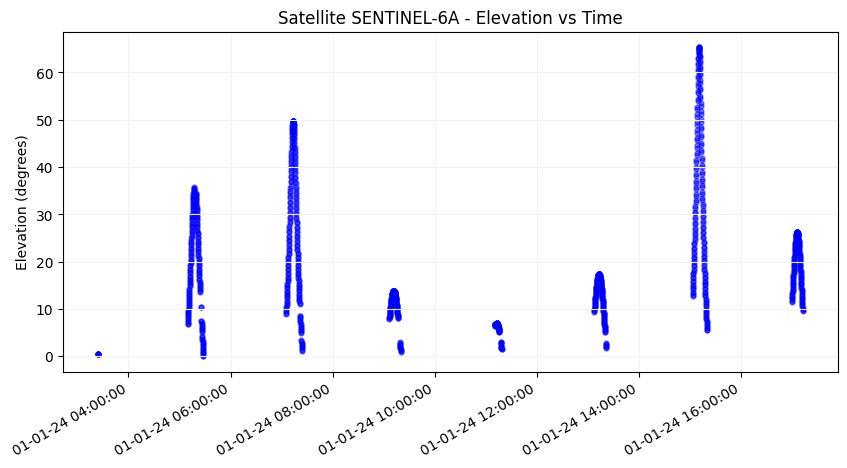

In [41]:
# ---- Scatter Plot Elevation ----
plt.figure(figsize=(10, 5))

plt.scatter([at2pt(ti) for ti in t], el_valid, alpha=0.5, s=12, c='blue')

plt.grid(color='0.95')
plt.ylabel("Elevation (degrees)")
plt.title(f"Satellite {rnx.sat_name} - Elevation vs Time")

# Format the datetime x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y %H:%M:%S"))
plt.gcf().autofmt_xdate()

plt.show()

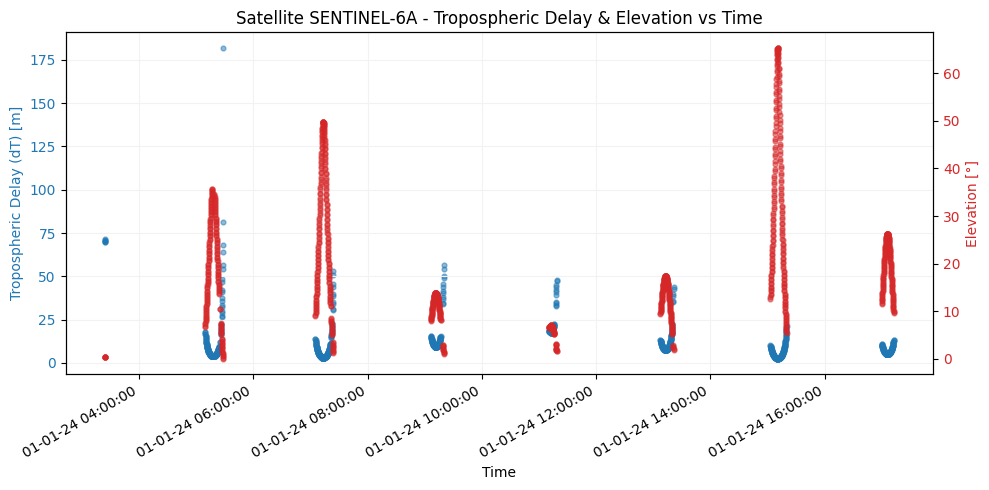

In [42]:
# ---- Combined Scatter Plot ----
fig, ax1 = plt.subplots(figsize=(10, 5))

# Πρώτος άξονας: Tropospheric Delay (dT)
color1 = 'tab:blue'
ax1.set_xlabel("Time")
ax1.set_ylabel("Tropospheric Delay (dT) [m]", color=color1)
ax1.scatter(t, dT_list, alpha=0.5, s=12, color=color1, label="dT")
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(color='0.95')

# Δεύτερος άξονας: Elevation
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel("Elevation [°]", color=color2)
ax2.scatter(t, el_valid, alpha=0.5, s=12, color=color2, label="Elevation")
ax2.tick_params(axis='y', labelcolor=color2)

# Format time axis
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y %H:%M:%S"))
fig.autofmt_xdate()

plt.title(f"Satellite {rnx.sat_name} - Tropospheric Delay & Elevation vs Time")
plt.tight_layout()
plt.show()

In [45]:
residuals = np.array(dl)        # ή όποια λίστα residuals έχεις
times = np.array(t)         # λίστα datetime ή indices

# Χρήση threshold (π.χ. ±0.3 m/s)
threshold = 0.3
mask = np.abs(residuals) <= threshold

# Φιλτραρισμένα δεδομένα
res_filtered = residuals[mask]
times_filtered = times[mask]

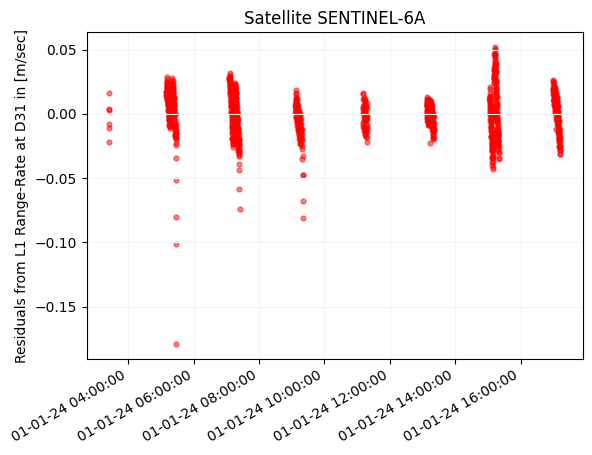

In [47]:
#plt.scatter([at2pt(ti) for ti in t], res2, alpha=0.5, s=12, c='blue')
plt.scatter([at2pt(ti) for ti in times_filtered], res_filtered, alpha=0.5, s=12, c='red')

plt.grid(color='0.95')
plt.ylabel(f"Residuals from L1 Range-Rate at {diob} in [m/sec]")
plt.title(f"Satellite {rnx.sat_name}")

# Format the datetime x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y %H:%M:%S"))
# auto-rotate date labels for readability
plt.gcf().autofmt_xdate()

plt.show()

## Correlation with Elevation

In [30]:
t1=None
els = []; res=[];
for block in rnx:
    for beacon, data in block:
        if beacon == diob:
            t2 = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset()*1e9)
            satx, saty, satz, _, _ = alg.sat_at_emission_time(diob_xyz, t2, intrp, None)
            L2 = data['L1']['value']
            r2 = np.linalg.norm(np.array([satx, saty, satz])-np.array(diob_xyz))
            _, _, el = azele(np.array((satx, saty, satz)), np.array(diob_xyz))
            if t1 is not None and (t2 - t1).total_seconds() <= 10.:
                crr = (r2 - r1) / (float((t2-t1).total_nanoseconds()) * 1e-9)
                orr = ((L2-L1) / (float((t2-t1).total_nanoseconds()) * 1e-9)) * (299792458./2036.25e6)
                if abs(orr - crr) > 100.:
                    pass
                else:
                    res.append(orr - crr)
                    els.append(np.degrees(el))
            r1 = r2
            t1 = t2
            L1 = L2

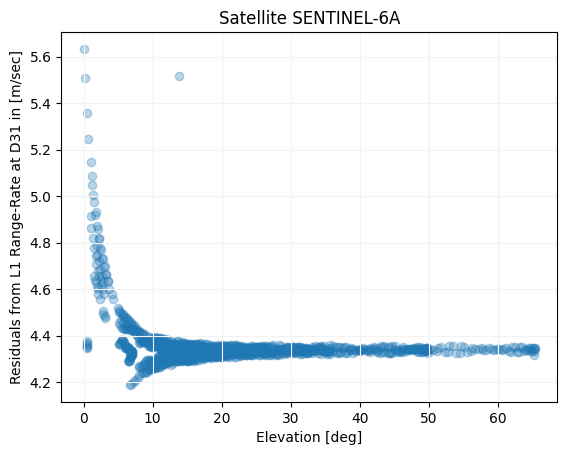

In [31]:
plt.scatter(els, res, alpha=0.3, marker='o')
plt.grid(color='0.95')
plt.ylabel(f"Residuals from L1 Range-Rate at {diob} in [m/sec]")
plt.xlabel("Elevation [deg]")
plt.title(f"Satellite {rnx.sat_name}")
plt.show()